# 2024 CITS4012 Project
Group 27
- 23625929

# Readme
IMPORTANT: Unless running this on something with >30GB VRAM, each model has to be loaded SEPARATELY into cuda. Only load, train and test one model at a time (follow the number label for the model), then use the provided cell under the testing section to free the cuda memory before training another (which means you can't just run all cells).

Do not clear cuda memory before running tests as the model still has to be in memory to complete test set.

The following models make use of pre-trained GloVe embeddings with dimension R^300. This is loaded using the TorchText library which is an optional addon when installing PyTorch.

Please fill in the paths with your path to the training, validation and test sets.

# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [1]:
# Note to marker: please fill these paths in
trining_data_path = "train.json"
validation_data_path = "val.json"
test_data_path = "test.json"

In [2]:
import json
import random
import nltk
import numpy as np

import matplotlib.pyplot as plt

import re
from nltk.tokenize import word_tokenize
nltk.download("punkt")

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torchtext.vocab import GloVe

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ethan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\ethan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\ethan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warn

In [3]:
# Contraction dict pulled from lab
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [4]:
# We will concatenate the training set and validation set for training
with open(trining_data_path, "r") as f:
    training = json.load(f)
with open(validation_data_path, "r") as f:
    validation = json.load(f)
    
data = training["data"] + validation["data"]

In [5]:
# Separate the raw sentence out from the data
train = [s[0] for s in data]
train = [s.lower() for s in train]

# Remove punctuation, replace contractions, apply nltk tokenisation to setences
def preprocess(sentences):
    output = []
    for sent in sentences:
        for word, new_word in contraction_dict.items():
            sent = sent.replace(word, new_word)
        sent = re.sub(r'[^\w\s]','',sent) #removing punctuation
        output.append(word_tokenize(sent))
    return output
            
tokens = preprocess(train)

In [6]:
# Load the Stanford GloVe 6B 300d model
glove = GloVe()
embedding = torch.nn.Embedding.from_pretrained(glove.vectors, freeze=True).to(device)

In [7]:
# Convert the tokens to the index within the GloVe embedding
def to_index(tokens, ix):
    input_index_list = []
    for sent in tokens:
        input_index_list.append([ix[w] for w in sent if w in ix])
    return input_index_list

indexed = to_index(tokens, glove.stoi)

In [8]:
# Convert the aspect to index within embedding
def aspect_to_index(data, ix):
    aspect_indices = []
    for sample in data:
        aspect_indices.append(ix[sample[1]])
    return aspect_indices

aspect = aspect_to_index(data, glove.stoi)

In [9]:
# Convert our labels to the target tensors associated with our inputs
def to_label(data):
    label_list = []
    polarity = {"negative": torch.tensor((1, 0, 0), dtype=torch.float32),
                "neutral": torch.tensor((0, 1, 0), dtype=torch.float32),
                "positive": torch.tensor((0, 0, 1), dtype=torch.float32)}
    for sample in data:
        label_list.append(polarity[sample[2]])

    return label_list

polarity = to_label(data)

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

I have implemented three models based on an LSTM architecture.
- 2.1 Attentionless Aspect Embedded LSTM    (AlAElstm)
- 2.2 Aspect Embedded LSTM with Attention   (AElstm)
- 2.3 Seq2Aspect LSTM with Attention        (Seq2Alstm)

The paper will refer to these models by their respective names, but section number will differ.

## Models and Training Functions

### 2.1 Attentionless Aspect Embedded LSTM

In [27]:
# Final output is used for sentiment analysis, thus sentiment is called after iterating through the sequence with forward pass

class AlAElstm(nn.Module):
    def __init__(self, hidden_size, embedding, dropout_p=0.5, n_layers=1):
        super(AlAElstm, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.embedding_size = embedding.embedding_dim
        self.dropout_p = dropout_p
        self.n_layers = n_layers

        self.lstm = nn.LSTM(self.embedding.embedding_dim * 2, hidden_size, self.n_layers, dropout=self.dropout_p)
        self.dropout = nn.Dropout(self.dropout_p)
        self.embedding_dropout = nn.Dropout(0.1)    # Used on all pre-trained embeddings instead of 0.5

        self.linear = nn.Linear(hidden_size, hidden_size)

        self.r_polarity = nn.Linear(hidden_size, 3)

    def sentiment(self, output):
        l1 = self.linear(output.squeeze())
        l1 = F.tanh(l1)
        l1 = self.dropout(l1)
        r = self.r_polarity(l1)
        return r
        
    def forward(self, hidden, word, aspect):       # Takes aspect embedding to concatenate onto input
        word_embedding = self.embedding_dropout(self.embedding(torch.tensor(word))).view(1, 1, -1)        
        aspect_embedding = self.embedding_dropout(self.embedding(torch.tensor(aspect))).view(1, 1, -1)

        input = torch.cat((word_embedding, aspect_embedding), dim=2)
        output, hidden = self.lstm(input, hidden)
        return output, hidden
    
    def initHidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size), torch.zeros(self.n_layers, 1, self.hidden_size))

### 2.2 Aspect Embedded LSTM with Attention

In [103]:
# Attention is fed into sentiment method which multiplies output hiddens before passing to linear to project to classification

class AElstm(nn.Module):
    def __init__(self, hidden_size, embedding, dropout_p=0.5, n_layers=1):
        super(AElstm, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.embedding_size = embedding.embedding_dim
        self.dropout_p = dropout_p
        self.n_layers = n_layers

        self.alpha_tensor = 0

        self.lstm = nn.LSTM(self.embedding.embedding_dim * 2, hidden_size, self.n_layers, dropout=self.dropout_p)
        self.dropout = nn.Dropout(self.dropout_p)
        self.embedding_dropout = nn.Dropout(0.1)    # used on all pre-trained embeddings isntead of 0.5

        self.W_h = nn.Linear(hidden_size, hidden_size)
        self.W_v = nn.Linear(self.embedding_size, self.embedding_size)

        self.w = nn.Linear(hidden_size + self.embedding_size, 1)

        self.r_polarity = nn.Linear(hidden_size, 3)

    def attention(self, encoder_outputs, aspect):
        projected_H = self.W_h(encoder_outputs)

        aspect_tensor = self.embedding_dropout(self.embedding(torch.tensor(aspect)).repeat(encoder_outputs.size(dim=0), 1))
        projected_V = self.W_v(aspect_tensor)

        h_v_cat = F.tanh(torch.cat((projected_H, projected_V), dim=1))
        h_v_cat = self.dropout(h_v_cat)

        alpha = F.softmax(self.w(h_v_cat), dim=0)

        if not self.training:
            self.alpha_tensor = alpha

        return alpha
    
    def sentiment(self, encoder_outputs, alpha):
        r = torch.mm(torch.transpose(encoder_outputs, 0, 1), alpha)
        return self.r_polarity(torch.flatten(r))
        
    def forward(self, hidden, word, aspect):       # Takes aspect embedding to concatenate onto input
        word_embedding = self.embedding_dropout(self.embedding(torch.tensor(word))).view(1, 1, -1)        
        aspect_embedding = self.embedding_dropout(self.embedding(torch.tensor(aspect))).view(1, 1, -1)

        input = torch.cat((word_embedding, aspect_embedding), dim=2)
        output, hidden = self.lstm(input, hidden)
        return output, hidden
    
    def return_attention(self):
        return self.alpha_tensor
    
    def initHidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size), torch.zeros(self.n_layers, 1, self.hidden_size))

### 2.3 Seq2Aspect LSTM with Attention

This is based off a Seq2Seq model but with the decoder being a single step that takes aspect as input. Therefore, there is an encoder and decoder network.

In [29]:
class EncoderSeq2Alstm(nn.Module):
    def __init__(self, hidden_size, embedding, dropout_p=0.5, n_layers=1):
        super(EncoderSeq2Alstm, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.embedding_size = embedding.embedding_dim
        self.dropout_p = dropout_p
        self.n_layers = n_layers

        self.embedding_dropout = nn.Dropout(0.1)    # used on all pre-trained embeddings

        self.lstm = nn.LSTM(self.embedding.embedding_dim * 2, hidden_size, self.n_layers, dropout=dropout_p)
        
    def forward(self, hidden, word, aspect):       # Takes aspect embedding to concatenate onto input
        word_embedding = self.embedding_dropout(self.embedding(torch.tensor(word))).view(1, 1, -1)
        aspect_embedding = self.embedding_dropout(self.embedding(torch.tensor(aspect))).view(1, 1, -1)
        
        input = torch.cat((word_embedding, aspect_embedding), dim=2)
        output, hidden = self.lstm(input, hidden)
        return output, hidden
    
    def initHidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size), torch.zeros(self.n_layers, 1, self.hidden_size))

In [30]:
class DecoderSeq2Alstm(nn.Module):
    def __init__(self, hidden_size, embedding, dropout_p=0.5, n_layers=1):
        super(DecoderSeq2Alstm, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.embedding_size = embedding.embedding_dim
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        self.alpha_tensor = 0   # will store attention tensor alpha to be returned in eval mode

        self.lstm = nn.LSTM(self.embedding.embedding_dim, hidden_size, self.n_layers, dropout=self.dropout_p)
        self.dropout = nn.Dropout(self.dropout_p)
        self.embedding_dropout = nn.Dropout(0.1)        # used on all pre-trained embeddings

        self.r_polarity = nn.Linear(hidden_size * 2, 3)
    
    def attention(self, output, encoder_outputs):       # uses scaled dot product attention
        alpha_distribution = F.softmax(torch.mm(output.squeeze(0), encoder_outputs.T/np.sqrt(self.hidden_size)), dim=-1)
        
        if not self.training:
            self.alpha_tensor = alpha_distribution
        
        alpha = torch.mm(alpha_distribution, encoder_outputs)
        alpha_h_cat = torch.cat((alpha, output.squeeze(0)), dim=1)

        return alpha_h_cat.squeeze(0)
    
    def forward(self, aspect, hidden, encoder_outputs):
        aspect_embedding = self.embedding_dropout(self.embedding(torch.tensor(aspect))).view(1, 1, -1)

        output,_ = self.lstm(aspect_embedding, hidden)

        alpha_h_cat = self.attention(output, encoder_outputs)
        alpha_h_cat = self.dropout(alpha_h_cat)

        return self.r_polarity(alpha_h_cat)
    
    def return_attention(self):
        return self.alpha_tensor

### Training Functions
These are functions to train the three specific networks.

In [31]:
# Train function for AlAElstm
def train_AlAElstm(encoder: AlAElstm, input, aspect, target, optimiser, criterion, current_iter, grad_accum=1):
    input_length = len(input)
    outputs_only = torch.zeros(input_length, encoder.hidden_size, device=device)
    
    hidden = encoder.initHidden()

    for i in range(input_length):
        output, hidden = encoder(hidden, input[i], aspect)
        outputs_only[i] = output[0, 0]

    sentiment = encoder.sentiment(output)

    loss = criterion(sentiment, target)
    loss.backward()

    if current_iter % grad_accum == 0:  # Gradient accumulation
        optimiser.step()
        optimiser.zero_grad()

    correct_pred = 0        # used for accuracy in reporting interval
    if torch.argmax(sentiment) == torch.argmax(target):
        correct_pred = 1

    return loss.item(), correct_pred

In [32]:
# Train function for AElstm
def train_AElstm(encoder: AElstm, input, aspect, target, optimiser, criterion, current_iter, grad_accum=1):
    input_length = len(input)
    outputs_only = torch.zeros(input_length, encoder.hidden_size, device=device)
    
    hidden = encoder.initHidden()

    for i in range(input_length):
        output, hidden = encoder(hidden, input[i], aspect)
        outputs_only[i] = output[0, 0]

    alpha = encoder.attention(outputs_only, aspect)
    sentiment = encoder.sentiment(outputs_only, alpha)

    loss = criterion(sentiment, target)
    loss.backward()

    if current_iter % grad_accum == 0:  # Gradient accumulation
        optimiser.step()
        optimiser.zero_grad()

    correct_pred = 0        # used for accuracy in reporting interval
    if torch.argmax(sentiment) == torch.argmax(target):
        correct_pred = 1

    return loss.item(), correct_pred

In [33]:
# Train function for Seq2Alstm
def train_Seq2Alstm(encoder: EncoderSeq2Alstm, 
                 decoder: DecoderSeq2Alstm, 
                 input, aspect, target, 
                 encoder_optimiser, 
                 decoder_optimiser,
                 criterion, current_iter, grad_accum=1):
    input_length = len(input)
    outputs_only = torch.zeros(input_length, encoder.hidden_size, device=device)
    
    hidden = encoder.initHidden()

    for i in range(input_length):
        output, hidden = encoder(hidden, input[i], aspect)
        outputs_only[i] = output[0, 0]

    sentiment = decoder(aspect, hidden, outputs_only)

    loss = criterion(sentiment, target)
    loss.backward()

    if current_iter % grad_accum == 0:
        encoder_optimiser.step()
        decoder_optimiser.step()

        encoder_optimiser.zero_grad()
        decoder_optimiser.zero_grad()
    
    correct_pred = 0        # used for accuracy in reporting interval
    if torch.argmax(sentiment) == torch.argmax(target):
        correct_pred = 1

    return loss.item(), correct_pred

## Model Training

### Training Model 2.1

In [50]:
# Hyperparameter initialisation
hidden_size = 300
learning_rate = 0.001
grad_accum = 10     # essentially batch size


encoder = AlAElstm(hidden_size, embedding, n_layers=2)
optimiser = optim.Adam(encoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [51]:
accuracy_log_21 = []       # this accuracy is cumulative across all training predictions
loss_log_21 = []
accuracy_log_freq = 20

train_iters = 30000
print_freq = 500
loss_total = 0
pred_total = 0

for i in range(1, train_iters+1):
    ix = random.randint(0, len(data)-1) # take random index from training data
    loss, pred = train_AlAElstm(encoder, indexed[ix], aspect[ix], polarity[ix], optimiser, criterion, i, grad_accum)
    loss_total += loss
    pred_total += pred
    
    if i % accuracy_log_freq == 0:  # log accuracy
        accuracy_log_21.append(pred_total/i)
    
    if i % print_freq == 0: # log loss
        loss_avg = loss_total/print_freq
        loss_log_21.append(loss_avg)

        accuracy_avg = pred_total/i # cumulative accuracy

        print(f"Iter: {i}   Loss: {round(loss_avg, 5)}    Accuracy: {round(accuracy_avg, 4)}")
        loss_total = 0

Iter: 500   Loss: 1.00193    Accuracy: 0.56
Iter: 1000   Loss: 0.94468    Accuracy: 0.574
Iter: 1500   Loss: 0.93861    Accuracy: 0.5667
Iter: 2000   Loss: 0.87676    Accuracy: 0.58
Iter: 2500   Loss: 0.88769    Accuracy: 0.5904
Iter: 3000   Loss: 0.93175    Accuracy: 0.588
Iter: 3500   Loss: 0.95495    Accuracy: 0.5863
Iter: 4000   Loss: 0.91422    Accuracy: 0.5887
Iter: 4500   Loss: 0.94111    Accuracy: 0.5902
Iter: 5000   Loss: 0.84927    Accuracy: 0.5948
Iter: 5500   Loss: 0.9182    Accuracy: 0.5944
Iter: 6000   Loss: 0.9051    Accuracy: 0.594
Iter: 6500   Loss: 0.87848    Accuracy: 0.5968
Iter: 7000   Loss: 0.93316    Accuracy: 0.5949
Iter: 7500   Loss: 0.92323    Accuracy: 0.5931
Iter: 8000   Loss: 0.90369    Accuracy: 0.5933
Iter: 8500   Loss: 0.88674    Accuracy: 0.5946
Iter: 9000   Loss: 0.87211    Accuracy: 0.5967
Iter: 9500   Loss: 0.91082    Accuracy: 0.5967
Iter: 10000   Loss: 0.89352    Accuracy: 0.5971
Iter: 10500   Loss: 0.92032    Accuracy: 0.5952
Iter: 11000   Loss: 0

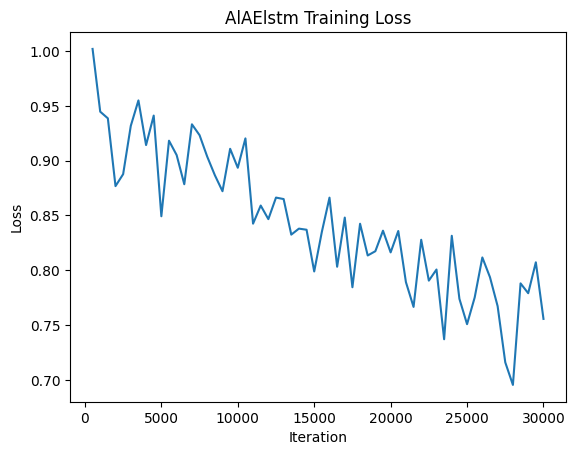

In [52]:
iterations = list(range(print_freq, len(loss_log_21) * print_freq + 1, print_freq))

plt.plot(iterations, loss_log_21)
plt.title("AlAElstm Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

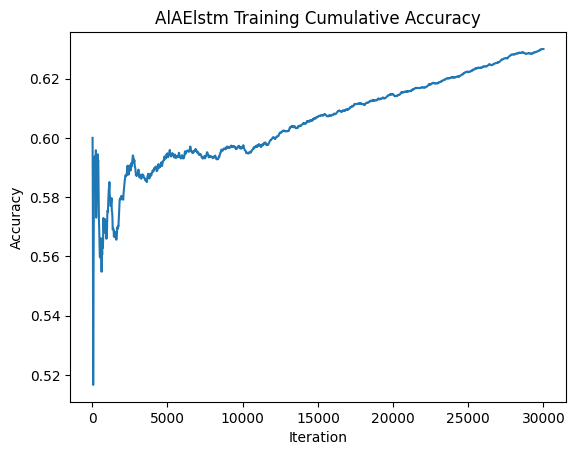

In [53]:
iterations = list(range(accuracy_log_freq, len(accuracy_log_21) * accuracy_log_freq + 1, accuracy_log_freq))

plt.plot(iterations, accuracy_log_21)
plt.title("AlAElstm Training Cumulative Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

### Training Model 2.2

In [119]:
# Hyperparameter initialisation
hidden_size = 300
learning_rate = 0.001
grad_accum = 10     # essentially batch size


encoder = AElstm(hidden_size, embedding, n_layers=2)
optimiser = optim.Adam(encoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [120]:
accuracy_log_22 = []       # this accuracy is cumulative across all training predictions
loss_log_22 = []
accuracy_log_freq = 20

train_iters = 30000
print_freq = 500
loss_total = 0
pred_total = 0

for i in range(1, train_iters+1):
    ix = random.randint(0, len(data)-1)
    loss, pred = train_AElstm(encoder, indexed[ix], aspect[ix], polarity[ix], optimiser, criterion, i, grad_accum)
    loss_total += loss
    pred_total += pred
    
    if i % accuracy_log_freq == 0:
        accuracy_log_22.append(pred_total/i)
    
    if i % print_freq == 0:
        loss_avg = loss_total/print_freq
        loss_log_22.append(loss_avg)

        accuracy_avg = pred_total/i

        print(f"Iter: {i}   Loss: {round(loss_avg, 5)}    Accuracy: {round(accuracy_avg, 4)}")
        loss_total = 0

Iter: 500   Loss: 0.97306    Accuracy: 0.542
Iter: 1000   Loss: 0.94826    Accuracy: 0.557
Iter: 1500   Loss: 0.86524    Accuracy: 0.582
Iter: 2000   Loss: 0.84994    Accuracy: 0.589
Iter: 2500   Loss: 0.86725    Accuracy: 0.5916
Iter: 3000   Loss: 0.81246    Accuracy: 0.6017
Iter: 3500   Loss: 0.89371    Accuracy: 0.6037
Iter: 4000   Loss: 0.85585    Accuracy: 0.6065
Iter: 4500   Loss: 0.86863    Accuracy: 0.6073
Iter: 5000   Loss: 0.86087    Accuracy: 0.6112
Iter: 5500   Loss: 0.78424    Accuracy: 0.6165
Iter: 6000   Loss: 0.84926    Accuracy: 0.6183
Iter: 6500   Loss: 0.80551    Accuracy: 0.6203
Iter: 7000   Loss: 0.82432    Accuracy: 0.6214
Iter: 7500   Loss: 0.87473    Accuracy: 0.6207
Iter: 8000   Loss: 0.76422    Accuracy: 0.624
Iter: 8500   Loss: 0.78701    Accuracy: 0.6258
Iter: 9000   Loss: 0.80457    Accuracy: 0.627
Iter: 9500   Loss: 0.81694    Accuracy: 0.6287
Iter: 10000   Loss: 0.79061    Accuracy: 0.6308
Iter: 10500   Loss: 0.77439    Accuracy: 0.6328
Iter: 11000   Loss

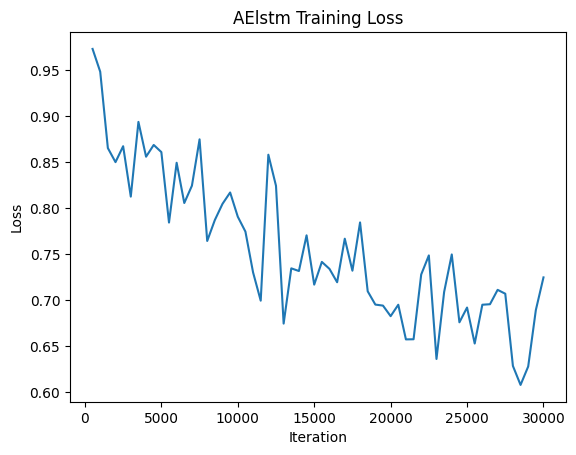

In [121]:
iterations = list(range(print_freq, len(loss_log_22) * print_freq + 1, print_freq))

plt.plot(iterations, loss_log_22)
plt.title("AElstm Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

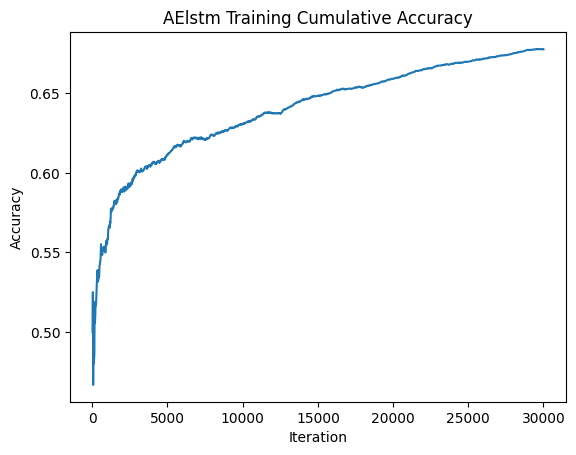

In [122]:
iterations = list(range(accuracy_log_freq, len(accuracy_log_22) * accuracy_log_freq + 1, accuracy_log_freq))

plt.plot(iterations, accuracy_log_22)
plt.title("AElstm Training Cumulative Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

### Training Model 2.3

In [71]:
# Hyperparameter initialisation
hidden_size = 300
learning_rate = 0.001
grad_accum = 10     # essentially batch size
n_layers = 2
dropout_p = 0.35

encoder = EncoderSeq2Alstm(hidden_size, embedding, n_layers=n_layers, dropout_p=dropout_p)
decoder = DecoderSeq2Alstm(hidden_size, embedding, n_layers=n_layers, dropout_p=dropout_p)
encoder_optimiser = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimiser = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [72]:
accuracy_log_23 = []       # this accuracy is cumulative across all training predictions
loss_log_23 = []
accuracy_log_freq = 20

train_iters = 30000
print_freq = 500
loss_total = 0
pred_total = 0
for i in range(1, train_iters+1):
    ix = random.randint(0, len(data)-1)
    loss, pred = train_Seq2Alstm(encoder, decoder, indexed[ix], aspect[ix], polarity[ix], encoder_optimiser, decoder_optimiser, criterion, i, grad_accum)
    loss_total += loss
    pred_total += pred
    
    if i % accuracy_log_freq == 0:
        accuracy_log_23.append(pred_total/i)
    
    if i % print_freq == 0:
        loss_avg = loss_total/print_freq
        loss_log_23.append(loss_avg)

        accuracy_avg = pred_total/i

        print(f"Iter: {i}   Loss: {round(loss_avg, 5)}    Accuracy: {round(accuracy_avg, 4)}")
        loss_total = 0

Iter: 500   Loss: 0.97032    Accuracy: 0.566
Iter: 1000   Loss: 0.91815    Accuracy: 0.583
Iter: 1500   Loss: 0.88375    Accuracy: 0.592
Iter: 2000   Loss: 0.89807    Accuracy: 0.597
Iter: 2500   Loss: 0.89147    Accuracy: 0.598
Iter: 3000   Loss: 0.89124    Accuracy: 0.5967
Iter: 3500   Loss: 0.89746    Accuracy: 0.5986
Iter: 4000   Loss: 0.87154    Accuracy: 0.6012
Iter: 4500   Loss: 0.88189    Accuracy: 0.6029
Iter: 5000   Loss: 0.86146    Accuracy: 0.6036
Iter: 5500   Loss: 0.87266    Accuracy: 0.6045
Iter: 6000   Loss: 0.86396    Accuracy: 0.6037
Iter: 6500   Loss: 0.86228    Accuracy: 0.6045
Iter: 7000   Loss: 0.83802    Accuracy: 0.6069
Iter: 7500   Loss: 0.84319    Accuracy: 0.6089
Iter: 8000   Loss: 0.81736    Accuracy: 0.6111
Iter: 8500   Loss: 0.81157    Accuracy: 0.6146
Iter: 9000   Loss: 0.81889    Accuracy: 0.6157
Iter: 9500   Loss: 0.77544    Accuracy: 0.6179
Iter: 10000   Loss: 0.80495    Accuracy: 0.6193
Iter: 10500   Loss: 0.81352    Accuracy: 0.62
Iter: 11000   Loss:

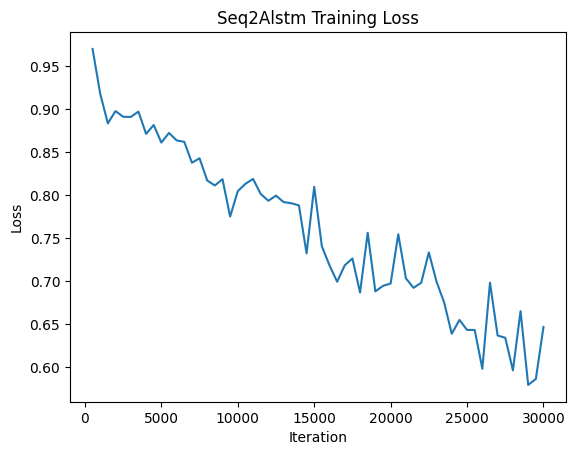

In [73]:
iterations = list(range(print_freq, len(loss_log_23) * print_freq + 1, print_freq))

plt.plot(iterations, loss_log_23)
plt.title("Seq2Alstm Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

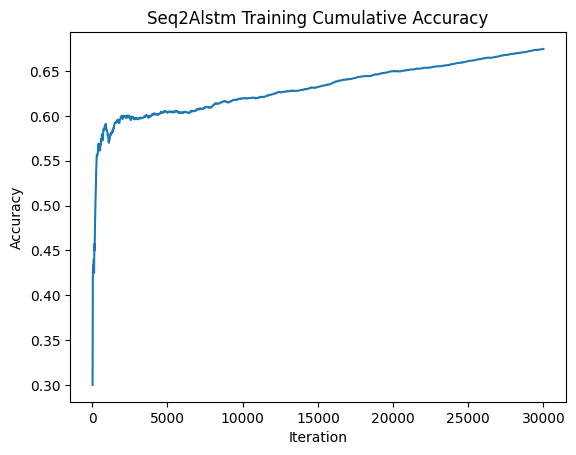

In [74]:
iterations = list(range(accuracy_log_freq, len(accuracy_log_23) * accuracy_log_freq + 1, accuracy_log_freq))

plt.plot(iterations, accuracy_log_23)
plt.title("Seq2Alstm Training Cumulative Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

### Comparison of training logs between all three

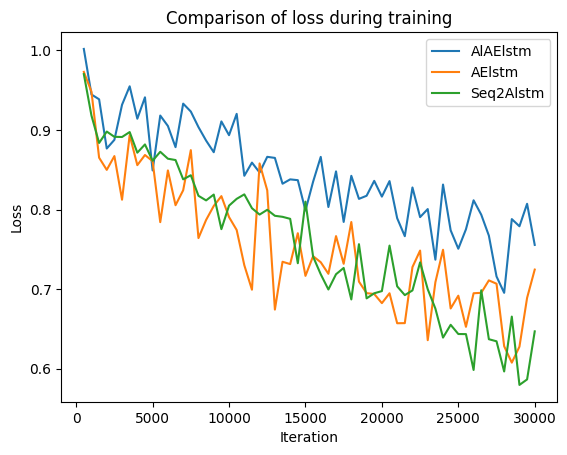

In [123]:
loss_iterations = list(range(print_freq, len(loss_log_23) * print_freq + 1, print_freq))

plt.plot(loss_iterations, loss_log_21, label="AlAElstm")
plt.plot(loss_iterations, loss_log_22, label="AElstm")
plt.plot(loss_iterations, loss_log_23, label="Seq2Alstm")

plt.title("Comparison of loss during training")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.legend()
plt.show()

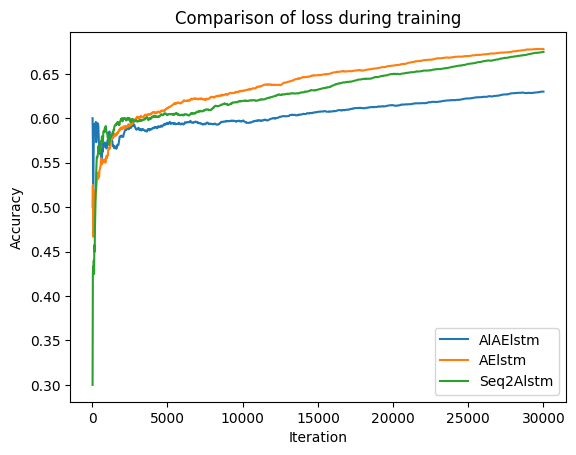

In [124]:
accuracy_iterations = list(range(accuracy_log_freq, len(accuracy_log_23) * accuracy_log_freq + 1, accuracy_log_freq))

plt.plot(accuracy_iterations, accuracy_log_21, label="AlAElstm")
plt.plot(accuracy_iterations, accuracy_log_22, label="AElstm")
plt.plot(accuracy_iterations, accuracy_log_23, label="Seq2Alstm")

plt.title("Comparison of loss during training")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [19]:
# Load test data
with open("test.json", "r") as f:
    training = json.load(f)
    
test_data = training["data"]

test = [s[0] for s in test_data]     # separates data out from labels
test = [s.lower() for s in test]

test_tok = preprocess(test)

test_indexed = to_index(test_tok, glove.stoi)
test_aspect = aspect_to_index(test_data, glove.stoi)
test_polarity = to_label(test_data)

### IMPORTANT: Run below cell to clear CUDA memory before running new model
Do not run before evaluation

In [118]:
del encoder
del decoder

NameError: name 'decoder' is not defined

### Evaluation Functions
Since each model is fed information slightly differently, this is reflected in the need for multiple evaluation functions.
These will all run on the test set.

In [125]:
# Evaluation of 2.1
def evaluateAlAElstm(encoder, input, aspect):
    encoder.eval()

    input_length = len(input)
    outputs_only = torch.zeros(input_length, encoder.hidden_size, device=device)

    hidden = encoder.initHidden()

    for i in range(input_length):
        output, hidden = encoder(hidden, input[i], aspect)
        outputs_only[i] = output[0, 0]

    sentiment = encoder.sentiment(output)
    polarity_index = torch.argmax(sentiment)

    return polarity_index

In [126]:
# Evaluation of 2.2
def evaluateAElstm(encoder, input, aspect):
    encoder.eval()

    input_length = len(input)
    outputs_only = torch.zeros(input_length, encoder.hidden_size, device=device)

    hidden = encoder.initHidden()

    for i in range(input_length):
        output, hidden = encoder(hidden, input[i], aspect)
        outputs_only[i] = output[0, 0]

    alpha = encoder.attention(outputs_only, aspect)
    sentiment = encoder.sentiment(outputs_only, alpha)
    polarity_index = torch.argmax(sentiment)

    return polarity_index

In [23]:
# Evaluation of 3.3
def evaluateSeq2Alstm(encoder, decoder, input, aspect):
    encoder.eval()
    decoder.eval()
    
    input_length = len(input)
    outputs_only = torch.zeros(input_length, encoder.hidden_size, device=device)

    hidden = encoder.initHidden()

    for i in range(input_length):
        output, hidden = encoder(hidden, input[i], aspect)
        outputs_only[i] = output[0, 0]

    sentiment = decoder(aspect, hidden, outputs_only)
    #print(sentiment)
    polarity_index = torch.argmax(sentiment)
    #print(alpha)
    return polarity_index

### Testing 2.1

In [54]:
correct = 0

for i in range(len(test_indexed)):
    res = evaluateAlAElstm(encoder, test_indexed[i], test_aspect[i])

    if torch.argmax(test_polarity[i]) == res:
        correct += 1

print(correct/len(test_indexed))

0.6537180910099889


### Testing 2.2

In [127]:
correct = 0

for i in range(len(test_indexed)):
    res = evaluateAElstm(encoder, test_indexed[i], test_aspect[i])

    if torch.argmax(test_polarity[i]) == res:
        correct += 1

print(correct/len(test_indexed))

0.7081021087680355


### Testing 2.3

In [77]:
correct = 0

for i in range(len(test_indexed)):
    res = evaluateSeq2Alstm(encoder, decoder, test_indexed[i], test_aspect[i])

    if torch.argmax(test_polarity[i]) == res:
        correct += 1

print(correct/len(test_indexed))

0.6859045504994451


## Exposing Attention

### Exposing attention state for AElstm

In [128]:
# Modify the evaluation function to capture the attention
def alpha_analysis(encoder, input, aspect):
    encoder.eval()

    input_length = len(input)
    outputs_only = torch.zeros(input_length, encoder.hidden_size, device=device)

    hidden = encoder.initHidden()

    for i in range(input_length):
        output, hidden = encoder(hidden, input[i], aspect)
        outputs_only[i] = output[0, 0]

    alpha = encoder.attention(outputs_only, aspect)
    sentiment = encoder.sentiment(outputs_only, alpha)

    return F.softmax(sentiment, dim=0).cpu().detach().numpy(), encoder.return_attention().T

def plot_attention(test_index, encoder):
    input = indexed[test_index]
    tokenised_input = tokens[test_index]

    label = aspect[test_index]
    target = polarity[test_index]

    pol_index, alpha = alpha_analysis(encoder, input, label)

    print("Sentence:", data[test_index][0])
    print("Aspect:", data[test_index][1])
    print("Target:", target.cpu().numpy())
    print("")
    print("Output:", pol_index)

    alpha = alpha.to("cpu").detach().numpy()

    plt.figure(figsize=(20,20))

    plt.pcolormesh(alpha, cmap="Greens")
    ax = plt.gca()
    ax.set_aspect('equal')

    plt.yticks([])
    plt.xticks([])

    for i, word in enumerate(tokenised_input):
        ax.text(i + 0.5, 0.5, word, ha='center', va='center', fontsize=10, color='black')

    plt.show()

Sentence: Although our waitress was pleasant and accomdating, the overpriced food was quite the opposite.
Aspect: food
Target: [1. 0. 0.]

Output: [0.6082471  0.04073534 0.3510175 ]


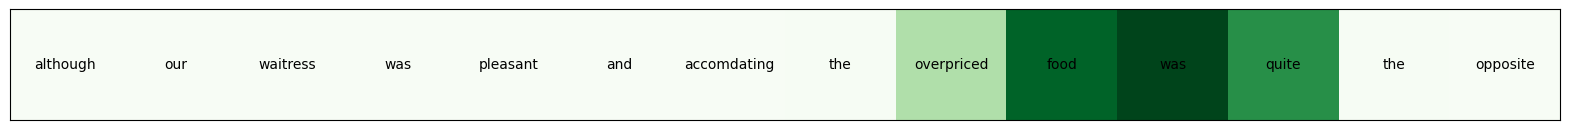

In [129]:
test_index = 173
plot_attention(test_index, encoder)

Sentence: Although our waitress was pleasant and accomdating, the overpriced food was quite the opposite.
Aspect: staff
Target: [0. 0. 1.]

Output: [0.05822314 0.00512853 0.93664837]


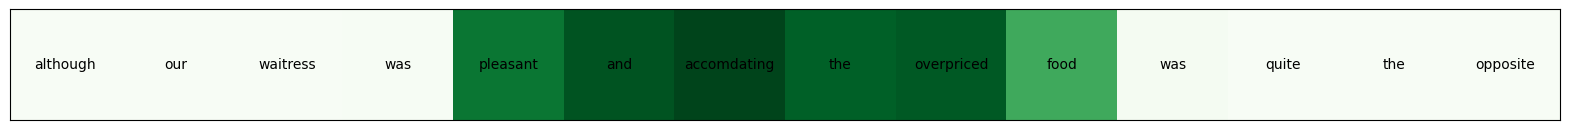

In [130]:
test_index = 172
plot_attention(test_index, encoder)

Sentence: My husband doesn't like vegetables and made a point to ask the waiter if he could have a side of pasta instead.
Aspect: food
Target: [1. 0. 0.]

Output: [0.16157785 0.79844785 0.03997435]


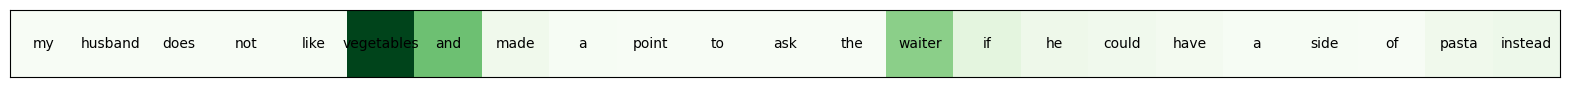

In [131]:
test_index = 859
plot_attention(test_index, encoder)

Sentence: My husband doesn't like vegetables and made a point to ask the waiter if he could have a side of pasta instead.
Aspect: staff
Target: [0. 1. 0.]

Output: [0.9200622  0.05060676 0.029331  ]


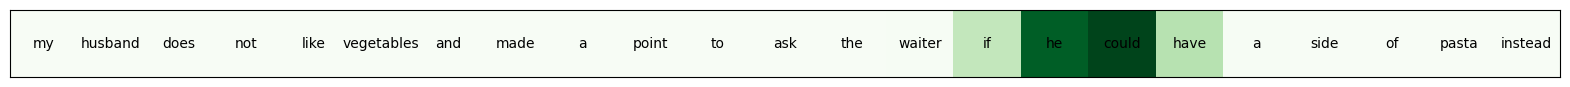

In [132]:
test_index = 860
plot_attention(test_index, encoder)

### Exposing attention state for Seq2Attention

Seq2Attention is the most novel model. We can set it to eval mode and call its ```return_attention()``` to recieve the attention tensor.

In [83]:
# Modify the evaluation function to capture the attention
def alpha_analysis(encoder, decoder, input, aspect):
    encoder.eval()
    decoder.eval()
    
    input_length = len(input)
    outputs_only = torch.zeros(input_length, encoder.hidden_size, device=device)

    hidden = encoder.initHidden()

    for i in range(input_length):
        output, hidden = encoder(hidden, input[i], aspect)
        outputs_only[i] = output[0, 0]

    sentiment = decoder(aspect, hidden, outputs_only)

    return F.softmax(sentiment, dim=0).cpu().detach().numpy(), decoder.return_attention()

# Function to visualise attention in graph
def plot_attention(test_index, encoder, decoder):
    input = indexed[test_index]
    tokenised_input = tokens[test_index]

    label = aspect[test_index]
    target = polarity[test_index]

    pol_index, alpha = alpha_analysis(encoder, decoder, input, label)

    print("Sentence:", data[test_index][0])
    print("Aspect:", data[test_index][1])
    print("Target:", target.cpu().numpy())
    print("")
    print("Output:", pol_index)

    alpha = alpha.to("cpu").detach().numpy()

    plt.figure(figsize=(20,20))

    plt.pcolormesh(alpha, cmap="Greens")
    ax = plt.gca()
    ax.set_aspect('equal')

    plt.yticks([])
    plt.xticks([])

    for i, word in enumerate(tokenised_input):
        ax.text(i + 0.5, 0.5, word, ha='center', va='center', fontsize=10, color='black')

    plt.show()

Sentence: Although our waitress was pleasant and accomdating, the overpriced food was quite the opposite.
Aspect: food
Target: [1. 0. 0.]

Output: [0.24508059 0.41292867 0.3419907 ]


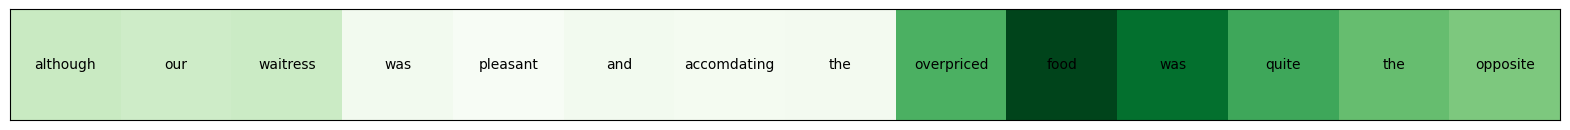

In [99]:
test_index = 173
plot_attention(test_index, encoder, decoder)

Sentence: Although our waitress was pleasant and accomdating, the overpriced food was quite the opposite.
Aspect: staff
Target: [0. 0. 1.]

Output: [0.12709783 0.019804   0.85309815]


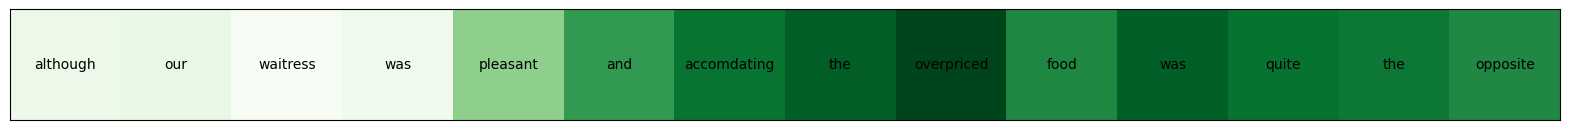

In [92]:
test_index = 172
plot_attention(test_index, encoder, decoder)

Sentence: My husband doesn't like vegetables and made a point to ask the waiter if he could have a side of pasta instead.
Aspect: food
Target: [1. 0. 0.]

Output: [0.06170808 0.9174334  0.02085856]


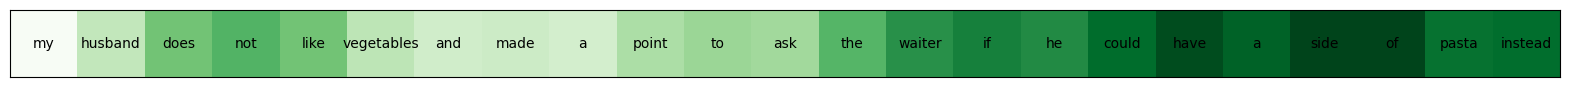

In [95]:
test_index = 859
plot_attention(test_index, encoder, decoder)

Sentence: My husband doesn't like vegetables and made a point to ask the waiter if he could have a side of pasta instead.
Aspect: staff
Target: [0. 1. 0.]

Output: [0.8655354  0.063004   0.07146066]


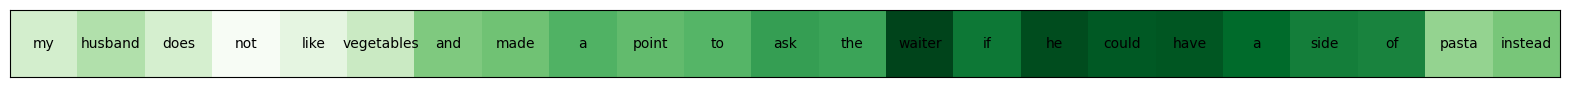

In [97]:
test_index = 860
plot_attention(test_index, encoder, decoder)

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*